In [ ]:
!pip install chembl-webresource-client rdkit

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for Colab
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All packages installed and imported successfully!")

✅ All packages installed and imported successfully!


In [ ]:
# Set up ChEMBL API clients
targets_api = new_client.target
bioactivities_api = new_client.activity
molecules_api = new_client.molecule

print("🔗 ChEMBL API clients initialized")
print("📡 Ready to query ChEMBL database")


🔗 ChEMBL API clients initialized
📡 Ready to query ChEMBL database


In [ ]:
def query_chembl_target(uniprot_id, target_organism="Homo sapiens"):
    """Query ChEMBL for target information using UniProt ID"""
    print(f"🔍 Searching for target with UniProt ID: {uniprot_id}")

    targets = targets_api.get(target_components__accession=uniprot_id).only(
        "target_chembl_id", "organism", "pref_name", "target_type"
    )

    targets_df = pd.DataFrame.from_records(targets)

    if targets_df.empty:
        raise ValueError(f"❌ No targets found for UniProt ID: {uniprot_id}")

    print("📋 Available targets:")
    display(targets_df)

    human_targets = targets_df[
        (targets_df['target_type'] == 'SINGLE PROTEIN') &
        (targets_df['organism'] == target_organism)
    ]

    if human_targets.empty:
        print(f"⚠️  No single protein targets found for {target_organism}")
        target = targets_df.iloc[0]
    else:
        target = human_targets.iloc[0]

    print(f"✅ Selected target: {target['pref_name']} ({target['target_chembl_id']})")
    return target['target_chembl_id']

print("🎯 Target query function defined")

🎯 Target query function defined


In [ ]:
def clean_bioactivity_data(bioactivities_df, activity_type="IC50"):
    """Clean and convert bioactivity data types"""
    print("🧹 Cleaning bioactivity data...")

    # Ensure standard_value is numeric
    bioactivities_df['standard_value'] = pd.to_numeric(
        bioactivities_df['standard_value'],
        errors='coerce'
    )

    # Remove rows where conversion failed
    bioactivities_df = bioactivities_df.dropna(subset=['standard_value'])

    # Calculate pIC50/pKi with proper type handling
    if activity_type in ["IC50", "Ki", "Kd"]:
        values = bioactivities_df['standard_value'].astype(float)
        bioactivities_df[f'p{activity_type}'] = -np.log10(values * 1e-9)

    return bioactivities_df

def query_bioactivities(target_chembl_id, activity_type="IC50"):
    """
    Query all bioactivities of a specific type with proper data cleaning.
    -- MODIFIED to remove min/max value filters --
    """
    print(f"🧪 Querying ALL {activity_type} bioactivities for target {target_chembl_id}...")

    bioactivities = bioactivities_api.filter(
        target_chembl_id=target_chembl_id,
        type=activity_type,
        relation="=",
        assay_type="B",
        standard_units="nM"
        # REMOVED: standard_value__gte and standard_value__lte filters
    ).only([
        "activity_id", "molecule_chembl_id", "standard_units",
        "standard_value", "target_chembl_id", "assay_description"
    ])

    bioactivities_df = pd.DataFrame.from_records(bioactivities)

    if bioactivities_df.empty:
        raise ValueError(f"❌ No {activity_type} bioactivities found")

    print(f"📊 Found {len(bioactivities_df)} {activity_type} bioactivities")

    # The clean_bioactivity_data function is still useful for data typing and pIC50 calculation
    bioactivities_df = clean_bioactivity_data(bioactivities_df, activity_type)

    print(f"✅ After cleaning: {len(bioactivities_df)} valid bioactivities")

    return bioactivities_df

In [ ]:
def get_compound_structures(bioactivities_df):
    """Retrieve compound structures from ChEMBL with proper API usage"""
    print("🧬 Retrieving compound structures...")

    # Convert numpy array to Python list
    molecule_ids = bioactivities_df['molecule_chembl_id'].unique().tolist()

    print(f"🔍 Fetching data for {len(molecule_ids)} unique molecules...")

    batch_size = 100
    all_molecules = []

    for i in range(0, len(molecule_ids), batch_size):
        batch_ids = molecule_ids[i:i + batch_size]
        print(f"   Processing batch {i//batch_size + 1}/{(len(molecule_ids)-1)//batch_size + 1}...")

        try:
            # FIXED: Use filter with molecule_chembl_id__in instead of get
            molecules = molecules_api.filter(molecule_chembl_id__in=batch_ids).only([
                'molecule_chembl_id', 'molecule_structures', 'max_phase',
                'molecular_weight', 'alogp', 'molecule_properties'
            ])

            # Convert to list and extend
            all_molecules.extend(list(molecules))

        except Exception as e:
            print(f"⚠️  Error in batch {i//batch_size + 1}: {str(e)}")
            # Fallback: try individual requests
            for mol_id in batch_ids:
                try:
                    molecule = molecules_api.filter(molecule_chembl_id=mol_id).only([
                        'molecule_chembl_id', 'molecule_structures', 'max_phase',
                        'molecular_weight', 'alogp', 'molecule_properties'
                    ])
                    all_molecules.extend(list(molecule))
                except:
                    print(f"     Skipping {mol_id}")
                    continue

    compounds_df = pd.DataFrame.from_records(all_molecules)

    if compounds_df.empty:
        raise ValueError("❌ No compound structures retrieved")

    compounds_df['canonical_smiles'] = compounds_df['molecule_structures'].apply(
        lambda x: x['canonical_smiles'] if x and isinstance(x, dict) and 'canonical_smiles' in x else None
    )

    compounds_df = compounds_df.dropna(subset=['canonical_smiles'])

    print(f"✅ Retrieved structures for {len(compounds_df)} compounds")
    return compounds_df

print("🧬 Structure retrieval function defined (CORRECTED)")

🧬 Structure retrieval function defined (CORRECTED)


In [ ]:
def calculate_adme_properties(compounds_df):
    """Calculate ADME properties using RDKit with proper imports"""
    print("⚗️  Calculating ADME properties...")

    # FIXED IMPORT for QED calculation
    from rdkit.Chem.QED import qed

    adme_properties = []

    for idx, row in compounds_df.iterrows():
        try:
            smiles = row['canonical_smiles']
            mol = Chem.MolFromSmiles(smiles)

            if mol is None:
                continue

            properties = {
                'molecule_chembl_id': row['molecule_chembl_id'],
                'smiles': smiles,
                'MW': float(Descriptors.MolWt(mol)),
                'LogP': float(Crippen.MolLogP(mol)),
                'HBD': int(rdMolDescriptors.CalcNumHBD(mol)),
                'HBA': int(rdMolDescriptors.CalcNumHBA(mol)),
                'TPSA': float(rdMolDescriptors.CalcTPSA(mol)),
                'RotBonds': int(rdMolDescriptors.CalcNumRotatableBonds(mol)),
                'AromaticRings': int(rdMolDescriptors.CalcNumAromaticRings(mol)),
                'QED': float(qed(mol))  # FIXED: Use qed(mol) instead of rdMolDescriptors.CalcQED(mol)
            }

            # Type conversion for rule calculations
            mw = float(properties['MW'])
            logp = float(properties['LogP'])
            hbd = int(properties['HBD'])
            hba = int(properties['HBA'])
            rotbonds = int(properties['RotBonds'])

            # Lipinski's Rule of Five
            properties['Lipinski_violations'] = sum([
                mw > 500, logp > 5, hbd > 5, hba > 10
            ])

            # Lead-likeness (Teague et al.)
            properties['Lead_like'] = all([
                250 <= mw <= 350, logp <= 3.5, rotbonds <= 7, hbd <= 3, hba <= 6
            ])

            # Drug-likeness (Lipinski)
            properties['Drug_like'] = properties['Lipinski_violations'] == 0

            adme_properties.append(properties)

        except (ValueError, TypeError) as e:
            print(f"⚠️  Skipping compound {row['molecule_chembl_id']}: {str(e)}")
            continue

    adme_df = pd.DataFrame(adme_properties)
    print(f"✅ Calculated ADME properties for {len(adme_df)} compounds")

    return adme_df

print("⚗️  ADME calculation function defined (QED FIXED)")

⚗️  ADME calculation function defined (QED FIXED)


In [ ]:
def create_colab_visualizations(final_df, drug_like_df, activity_type="IC50"):
    """Create Colab-optimized visualizations"""
    print("📈 Creating visualizations...")

    plt.style.use('default')
    sns.set_palette("husl")

    # Plot 1: Activity distribution
    if f'p{activity_type}' in final_df.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(final_df[f'p{activity_type}'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel(f'p{activity_type}', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'{activity_type} Activity Distribution', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Plot 2: MW vs LogP scatter
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(final_df['MW'], final_df['LogP'],
                         c=final_df[f'p{activity_type}'] if f'p{activity_type}' in final_df.columns else 'blue',
                         alpha=0.6, cmap='viridis', s=50)
    plt.xlabel('Molecular Weight', fontsize=12)
    plt.ylabel('LogP', fontsize=12)
    plt.title('Molecular Weight vs LogP', fontsize=14, fontweight='bold')
    if f'p{activity_type}' in final_df.columns:
        cbar = plt.colorbar(scatter)
        cbar.set_label(f'p{activity_type}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot 3: Drug-likeness pie chart
    drug_like_counts = final_df['Drug_like'].value_counts()
    plt.figure(figsize=(8, 8))
    colors = ['#ff9999', '#66b3ff']
    plt.pie(drug_like_counts.values, labels=['Non-drug-like', 'Drug-like'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12})
    plt.title('Drug-likeness Distribution', fontsize=14, fontweight='bold')
    plt.show()

    # Plot 4: ADME properties comparison
    plt.figure(figsize=(12, 6))
    properties = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA']
    x_pos = np.arange(len(properties))

    all_means = [final_df[prop].mean() for prop in properties]
    drug_means = [drug_like_df[prop].mean() for prop in properties if len(drug_like_df) > 0]

    width = 0.35
    plt.bar(x_pos - width/2, all_means, width, label='All compounds', alpha=0.7, color='lightblue')
    if len(drug_means) == len(properties):
        plt.bar(x_pos + width/2, drug_means, width, label='Drug-like', alpha=0.7, color='lightcoral')

    plt.xlabel('Properties', fontsize=12)
    plt.ylabel('Mean Values', fontsize=12)
    plt.title('ADME Properties Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x_pos, properties)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

print("📈 Visualization functions defined")

📈 Visualization functions defined


In [ ]:
def run_chembl_analysis(uniprot_id="P00533", activity_type="IC50", activity_threshold=10000):
    """
    Main function to run the complete ChEMBL analysis.
    """
    print("🚀 Starting ChEMBL Analysis in Google Colab")
    print("=" * 50)
    print(f"Target UniProt ID: {uniprot_id}")
    print(f"Activity type: {activity_type}")
    print(f"Activity Threshold for 'active': <= {activity_threshold} nM")
    print("=" * 50)

    try:
        # Step 1: Query target
        target_chembl_id = query_chembl_target(uniprot_id)

        # Step 2: Query bioactivities
        bioactivities_df = query_bioactivities(target_chembl_id, activity_type)

        # Step 3: Get compound structures
        compounds_df = get_compound_structures(bioactivities_df)

        # Step 4: Calculate ADME properties
        adme_df = calculate_adme_properties(compounds_df)

        # Step 5: Merge and process data
        final_df = bioactivities_df.merge(adme_df, on='molecule_chembl_id', how='inner')

        # --- FIX for infinity values in pIC50 ---
        activity_col = f'p{activity_type}'
        if activity_col in final_df.columns:
            # Replace infinite values with NaN (Not a Number)
            final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
            # Remove rows with NaN in the pIC50 column
            final_df.dropna(subset=[activity_col], inplace=True)
            print(f"✅ Removed rows with infinite p{activity_type} values.")
        # --- END FIX ---

        # Step 6: Classify compounds as active or inactive
        print("\n🔬 Classifying bioactivity...")

        def classify_activity(value, threshold):
            if pd.isna(value):
                return "Undefined"
            elif float(value) <= threshold:
                return "Active"
            else:
                return "Inactive"

        final_df['bioactivity_class'] = final_df['standard_value'].apply(
            lambda x: classify_activity(x, activity_threshold)
        )
        print(f"✅ Compounds classified based on {activity_type} <= {activity_threshold} nM threshold.")


        # Step 7: Final processing and sorting
        if activity_col in final_df.columns:
            final_df = final_df.sort_values(activity_col, ascending=False)
        final_df = final_df.drop_duplicates(subset=['molecule_chembl_id'], keep='first')

        drug_like_df = final_df[final_df['Drug_like'] == True]
        lead_like_df = final_df[final_df['Lead_like'] == True]

        # MODIFIED: Update results summary to include active/inactive counts and prevent division by zero
        print(f"\n📊 RESULTS SUMMARY")
        print("=" * 30)
        print(f"Total compounds retrieved: {len(final_df)}")
        if 'bioactivity_class' in final_df.columns:
            print(final_df['bioactivity_class'].value_counts())
        print("-" * 30)
        print(f"Drug-like compounds: {len(drug_like_df)} ({len(drug_like_df)/len(final_df)*100:.1f}% if len(final_df) > 0 else 0)")
        print(f"Lead-like compounds: {len(lead_like_df)} ({len(lead_like_df)/len(final_df)*100:.1f}% if len(final_df) > 0 else 0)")


        print(f"\n📋 Data Preview (notice the new 'bioactivity_class' column):")
        display(final_df.head())

        # Create visualizations
        create_colab_visualizations(final_df, drug_like_df, activity_type)

        # Save results
        final_df.to_csv(f'chembl_results_{uniprot_id}_{activity_type}_classified.csv', index=False)
        print(f"💾 Results saved as: chembl_results_{uniprot_id}_{activity_type}_classified.csv")

        return final_df, drug_like_df, lead_like_df

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None, None, None

In [ ]:
# Display example targets
print("🎯 EXAMPLE TARGETS TO TRY:")
print("=" * 40)
print("P00533 - EGFR (Epidermal Growth Factor Receptor)")
print("P04637 - p53 tumor suppressor")
print("P24941 - CDK2 kinase")
print("P15056 - BRAF kinase")
print("Q9UM73 - ALK kinase")
print("P42336 - PI3K alpha")
print("P00519 - ABL1 kinase")
print("P06239 - LCK kinase")
print("\n💡 Change the parameters in the next cell to analyze different targets!")

🎯 EXAMPLE TARGETS TO TRY:
P00533 - EGFR (Epidermal Growth Factor Receptor)
P04637 - p53 tumor suppressor
P24941 - CDK2 kinase
P15056 - BRAF kinase
Q9UM73 - ALK kinase
P42336 - PI3K alpha
P00519 - ABL1 kinase
P06239 - LCK kinase

💡 Change the parameters in the next cell to analyze different targets!


#VISFATIN (NAMPT) · P43490

🚀 Starting ChEMBL Analysis in Google Colab
Target UniProt ID: P43490
Activity type: IC50
Activity Threshold for 'active': <= 10000 nM
🔍 Searching for target with UniProt ID: P43490
📋 Available targets:


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Nicotinamide phosphoribosyltransferase,CHEMBL1744525,SINGLE PROTEIN
1,Homo sapiens,Nicotinamide phosphoribosyltransferase,CHEMBL1744525,SINGLE PROTEIN
2,Homo sapiens,VHL/Nicotinamide phosphoribosyltransferase,CHEMBL5465234,PROTEIN-PROTEIN INTERACTION


✅ Selected target: Nicotinamide phosphoribosyltransferase (CHEMBL1744525)
🧪 Querying ALL IC50 bioactivities for target CHEMBL1744525...
📊 Found 2681 IC50 bioactivities
🧹 Cleaning bioactivity data...
✅ After cleaning: 2681 valid bioactivities
🧬 Retrieving compound structures...
🔍 Fetching data for 2377 unique molecules...
   Processing batch 1/24...
   Processing batch 2/24...
   Processing batch 3/24...
   Processing batch 4/24...
   Processing batch 5/24...
   Processing batch 6/24...
   Processing batch 7/24...
   Processing batch 8/24...
   Processing batch 9/24...
   Processing batch 10/24...
   Processing batch 11/24...
   Processing batch 12/24...
   Processing batch 13/24...
   Processing batch 14/24...
   Processing batch 15/24...
   Processing batch 16/24...
   Processing batch 17/24...
   Processing batch 18/24...
   Processing batch 19/24...
   Processing batch 20/24...
   Processing batch 21/24...
   Processing batch 22/24...
   Processing batch 23/24...
   Processing batch

,activity_id,assay_description,molecule_chembl_id,standard_units,standard_value,target_chembl_id,units,value,pIC50,smiles,...,HBD,HBA,TPSA,RotBonds,AromaticRings,QED,Lipinski_violations,Lead_like,Drug_like,bioactivity_class
442,16448830,Inhibition of NAMPT in human SH-SY5Y cells ass...,CHEMBL566757,nM,0.0301,CHEMBL1744525,pM,30.1,10.521434,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,...,1,3,62.30,8,2,0.547721,0,False,True,Active
441,16448829,Inhibition of NAMPT in human SH-SY5Y cells ass...,CHEMBL3753643,nM,0.0509,CHEMBL1744525,pM,50.9,10.293282,O=C(/C=C/c1cccnc1)NCCCCCc1cn(-c2ccccc2-c2ccccc...,...,1,5,72.70,10,4,0.283715,0,False,True,Active
2668,25599112,Inhibition of recombinant human NAMPT preincub...,CHEMBL5429026,nM,0.1500,CHEMBL1744525,nM,0.15,9.823909,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2cccc(N(CCC...,...,1,4,65.54,13,2,0.218840,2,False,False,Active
2578,19403758,Inhibition of NAMPT in human MCF7 cells assess...,CHEMBL4544378,nM,0.1550,CHEMBL1744525,nM,0.155,9.809668,CC(C)N(CCc1c[nH]c2ccccc12)Cc1ccc(NCCCCCNC(=O)/...,...,3,4,73.05,15,4,0.124048,2,False,False,Active
2667,25599111,Inhibition of recombinant human NAMPT preincub...,CHEMBL5437893,nM,0.1600,CHEMBL1744525,nM,0.16,9.795880,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2N(CC...,...,1,4,65.54,13,2,0.218840,2,False,False,Active


📈 Creating visualizations...


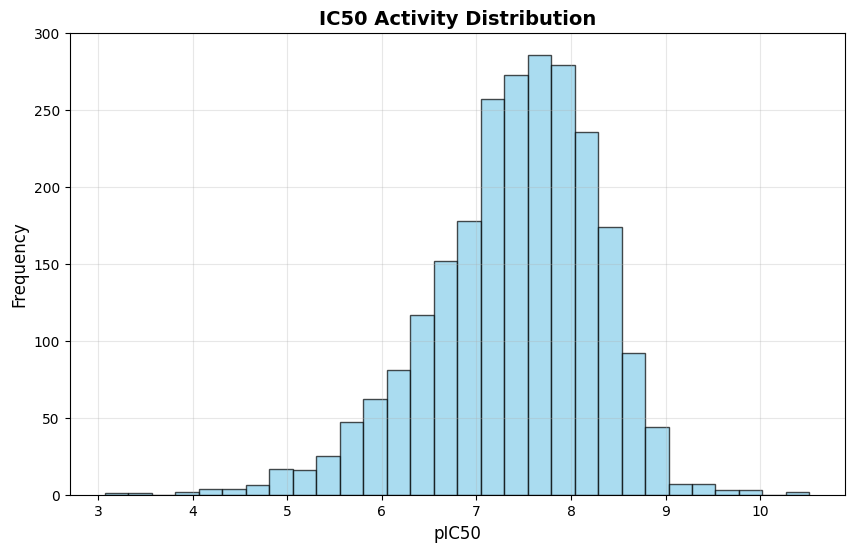

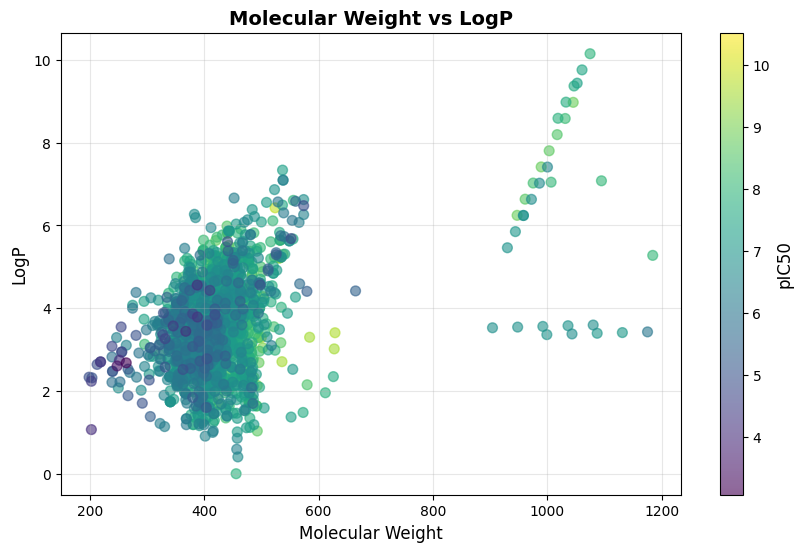

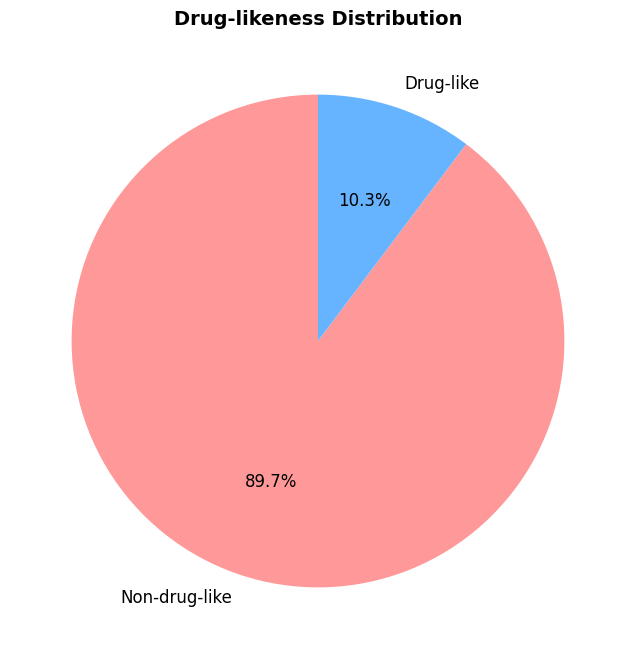

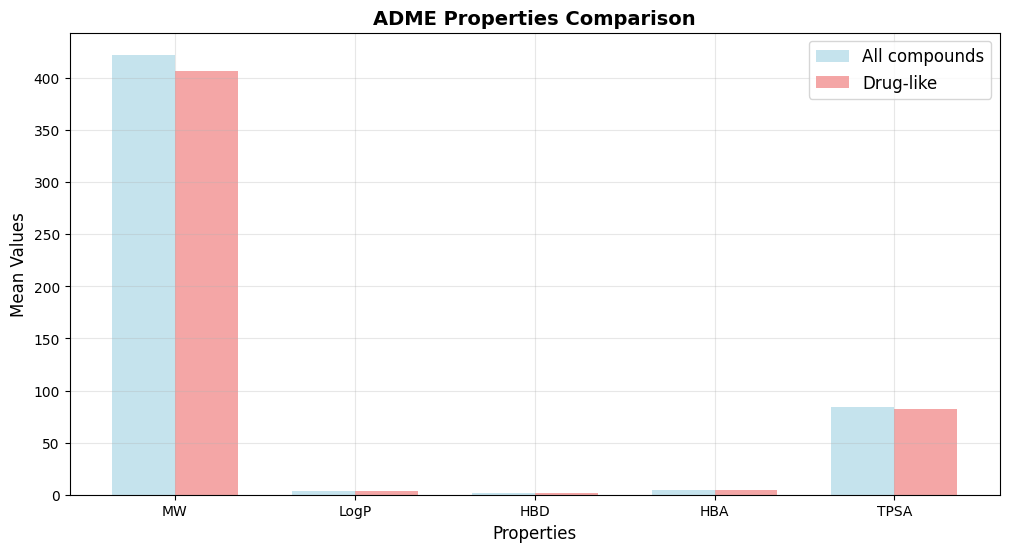

💾 Results saved as: chembl_results_P43490_IC50_classified.csv
✅ Analysis completed successfully!
📊 Data available in: final_df, drug_like_df, lead_like_df


In [ ]:
# Execute the analysis - MODIFY THESE PARAMETERS
results = run_chembl_analysis(
    uniprot_id="P43490",             # Target UniProt ID
    activity_type="IC50",            # Options: IC50, Ki, Kd, etc.
    activity_threshold=10000             # Threshold in nM to classify as "active"
)

# Unpack results for further analysis
if results[0] is not None:
    final_df, drug_like_df, lead_like_df = results
    print("✅ Analysis completed successfully!")
    print("📊 Data available in: final_df, drug_like_df, lead_like_df")
else:
    print("❌ Analysis failed - check error messages above")

# BACE1 · P56817


🚀 Starting ChEMBL Analysis in Google Colab
Target UniProt ID: P56817
Activity type: IC50
Activity Threshold for 'active': <= 10000 nM
🔍 Searching for target with UniProt ID: P56817
📋 Available targets:


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Beta-secretase 1,CHEMBL4822,SINGLE PROTEIN
1,Homo sapiens,Beta-secretase 1,CHEMBL4822,SINGLE PROTEIN
2,Homo sapiens,Beta-secretase (BACE),CHEMBL2111390,PROTEIN FAMILY


✅ Selected target: Beta-secretase 1 (CHEMBL4822)
🧪 Querying ALL IC50 bioactivities for target CHEMBL4822...
📊 Found 9829 IC50 bioactivities
🧹 Cleaning bioactivity data...
✅ After cleaning: 9829 valid bioactivities
🧬 Retrieving compound structures...
🔍 Fetching data for 6912 unique molecules...
   Processing batch 1/70...
   Processing batch 2/70...
   Processing batch 3/70...
   Processing batch 4/70...
   Processing batch 5/70...
   Processing batch 6/70...
   Processing batch 7/70...
   Processing batch 8/70...
   Processing batch 9/70...
   Processing batch 10/70...
   Processing batch 11/70...
   Processing batch 12/70...
   Processing batch 13/70...
   Processing batch 14/70...
   Processing batch 15/70...
   Processing batch 16/70...
   Processing batch 17/70...
   Processing batch 18/70...
   Processing batch 19/70...
   Processing batch 20/70...
   Processing batch 21/70...
   Processing batch 22/70...
   Processing batch 23/70...
   Processing batch 24/70...
   Processing batc

,activity_id,assay_description,molecule_chembl_id,standard_units,standard_value,target_chembl_id,units,value,pIC50,smiles,...,HBD,HBA,TPSA,RotBonds,AromaticRings,QED,Lipinski_violations,Lead_like,Drug_like,bioactivity_class
7696,17745668,Cellular Aβ-Lowering Assay: The Abeta 40 Alpha...,CHEMBL3969403,nM,0.0002,CHEMBL4822,nM,0.0002,12.698970,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,...,2,7,138.30,3,2,0.766301,0,False,True,Active
7695,17745667,Cellular Aβ-Lowering Assay: The Abeta 40 Alpha...,CHEMBL3261078,nM,0.0009,CHEMBL4822,nM,0.0009,12.045757,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(Cl)cn3)cc...,...,2,6,114.51,3,2,0.764113,0,False,True,Active
7697,17745669,Cellular Aβ-Lowering Assay: The Abeta 40 Alpha...,CHEMBL3937515,nM,0.0009,CHEMBL4822,nM,0.0009,12.045757,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,...,2,8,136.63,4,2,0.744965,0,False,True,Active
7699,17745671,Cellular Aβ-Lowering Assay: The Abeta 40 Alpha...,CHEMBL3949213,nM,0.0010,CHEMBL4822,nM,0.001,12.000000,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,...,2,7,138.30,3,2,0.729565,0,False,True,Active
7698,17745670,Cellular Aβ-Lowering Assay: The Abeta 40 Alpha...,CHEMBL3955051,nM,0.0018,CHEMBL4822,nM,0.0018,11.744727,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,...,2,7,127.40,4,2,0.729535,0,False,True,Active


📈 Creating visualizations...


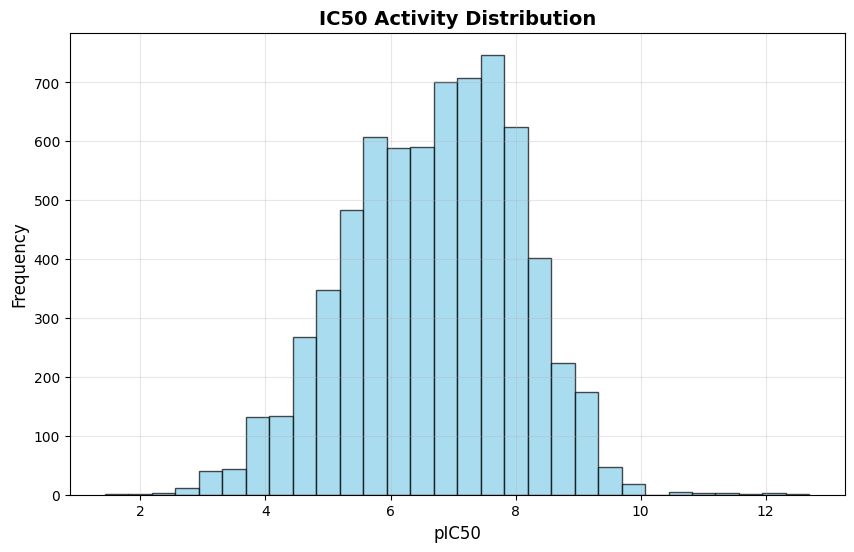

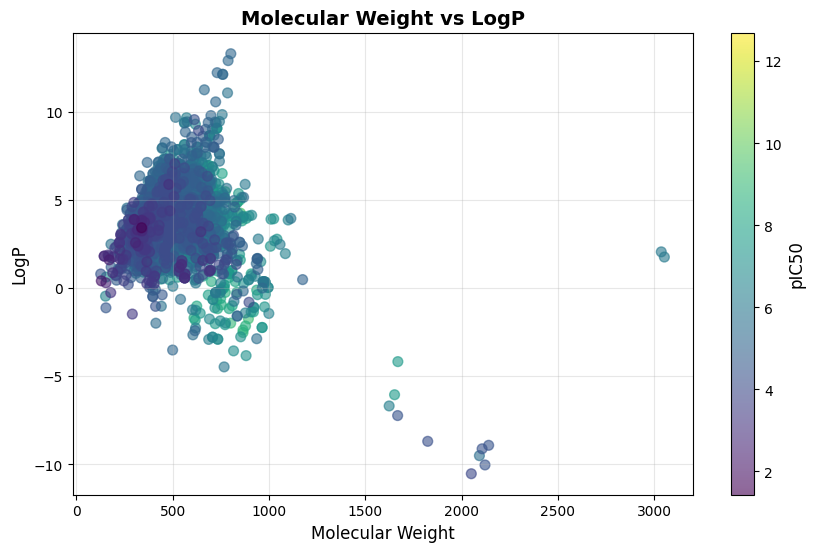

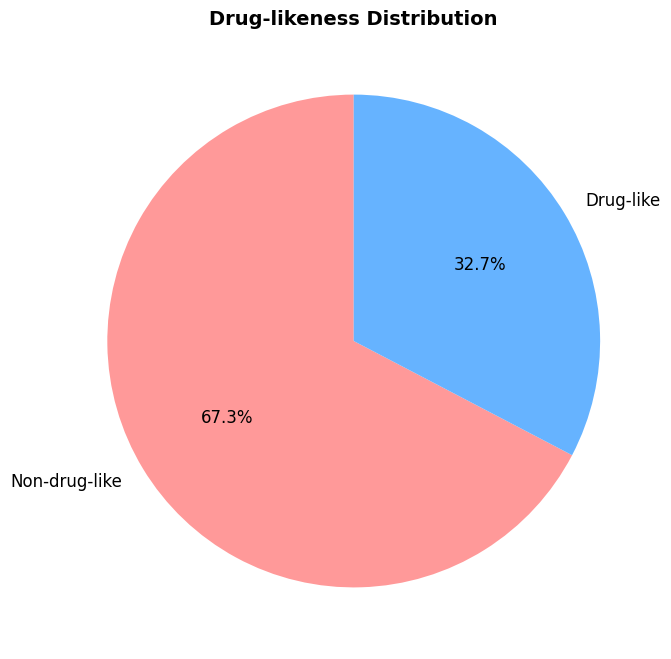

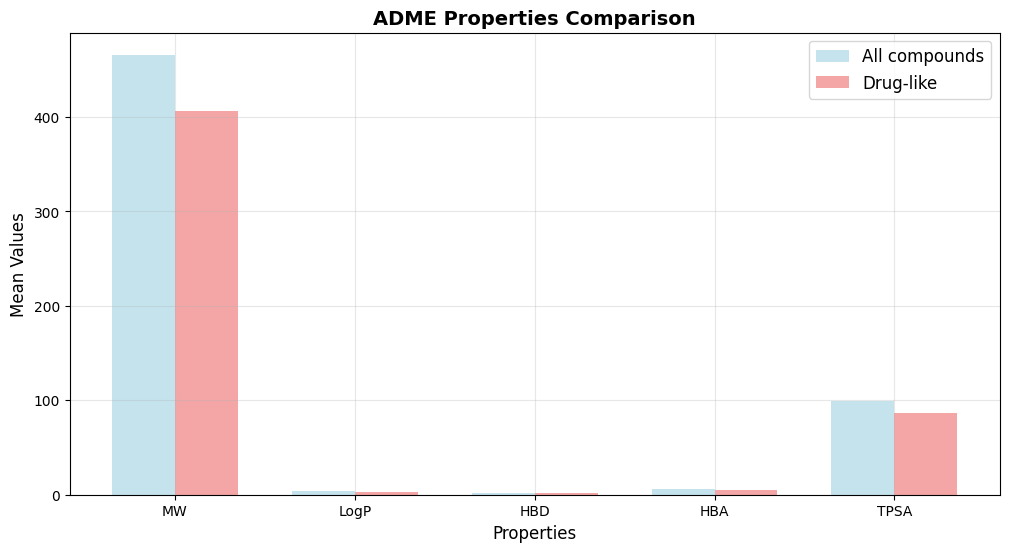

💾 Results saved as: chembl_results_P56817_IC50_classified.csv
✅ Analysis completed successfully!
📊 Data available in: final_df, drug_like_df, lead_like_df


In [ ]:
# Execute the analysis - MODIFY THESE PARAMETERS
results = run_chembl_analysis(
    uniprot_id="P56817",             # Target UniProt ID (e.g., BACE1)
    activity_type="IC50",            # Options: IC50, Ki, Kd, etc.
    activity_threshold=10000         # Threshold in nM to classify as "active"
)

# Unpack results for further analysis
if results[0] is not None:
    final_df, drug_like_df, lead_like_df = results
    print("✅ Analysis completed successfully!")
    print("📊 Data available in: final_df, drug_like_df, lead_like_df")
else:
    print("❌ Analysis failed - check error messages above")

# ACHE · Q04844

🚀 Starting ChEMBL Analysis in Google Colab
Target UniProt ID: Q04844
Activity type: IC50
Activity Threshold for 'active': <= 1000 nM
🔍 Searching for target with UniProt ID: Q04844
📋 Available targets:


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Acetylcholine receptor protein epsilon chain,CHEMBL2484,SINGLE PROTEIN
1,Homo sapiens,Acetylcholine receptor protein epsilon chain,CHEMBL2484,SINGLE PROTEIN
2,Homo sapiens,Muscle-type nicotinic acetylcholine receptor,CHEMBL2362997,PROTEIN COMPLEX GROUP
3,Homo sapiens,Nicotinic acetylcholine receptor alpha-1/beta-...,CHEMBL4106145,PROTEIN COMPLEX
4,Homo sapiens,Nicotinic Acetylcholine Receptor,CHEMBL4524133,PROTEIN COMPLEX GROUP


✅ Selected target: Acetylcholine receptor protein epsilon chain (CHEMBL2484)
🧪 Querying ALL IC50 bioactivities for target CHEMBL2484...
📊 Found 16 IC50 bioactivities
🧹 Cleaning bioactivity data...
✅ After cleaning: 16 valid bioactivities
🧬 Retrieving compound structures...
🔍 Fetching data for 15 unique molecules...
   Processing batch 1/1...
✅ Retrieved structures for 15 compounds
⚗️  Calculating ADME properties...
✅ Calculated ADME properties for 15 compounds

🔬 Classifying bioactivity...
✅ Compounds classified based on IC50 <= 1000 nM threshold.

📊 RESULTS SUMMARY
Total compounds retrieved: 15
bioactivity_class
Active      12
Inactive     3
Name: count, dtype: int64
------------------------------
Drug-like compounds: 5 (33.3%)
Lead-like compounds: 0 (0.0%)

📋 Data Preview (notice the new 'bioactivity_class' column):


,activity_id,assay_description,molecule_chembl_id,standard_units,standard_value,target_chembl_id,units,value,pIC50,smiles,...,HBD,HBA,TPSA,RotBonds,AromaticRings,QED,Lipinski_violations,Lead_like,Drug_like,bioactivity_class
5,19099394,Inhibition of AChE (unknown origin) after 2 mins,CHEMBL4435544,nM,6.0,CHEMBL2484,nM,6.0,8.221849,O=c1ccc2ccc(OCCCCCCCn3cc(CNc4c5c(nc6ccccc46)CC...,...,1,8,95.07,12,5,0.144258,2,False,False,Active
4,19099393,Inhibition of AChE (unknown origin) after 2 mins,CHEMBL4471876,nM,27.0,CHEMBL2484,nM,27.0,7.568636,Cc1cc(=O)oc2cc(OCCCCCn3cc(CNc4c5c(nc6cc(Cl)ccc...,...,1,8,95.07,10,5,0.151900,2,False,False,Active
0,1847078,Inhibition of acetylcholinesterase,CHEMBL95,nM,44.0,CHEMBL2484,nM,44.0,7.356547,Nc1c2c(nc3ccccc13)CCCC2,...,1,2,38.91,0,2,0.706488,0,False,True,Active
10,19099448,Inhibition of AChE (unknown origin) by Ellman'...,CHEMBL4518438,nM,46.5,CHEMBL2484,uM,0.0465,7.332547,Cc1nn(CC(=O)N/N=C/c2ccccc2)c(=O)n1-c1ccc(C(=O)...,...,2,8,122.74,8,4,0.296002,0,False,True,Active
3,18568214,Inhibition of nAChR epsilon (unknown origin),CHEMBL4228909,nM,50.0,CHEMBL2484,nM,50.0,7.301030,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,...,31,34,965.52,62,3,0.010801,3,False,False,Active


📈 Creating visualizations...


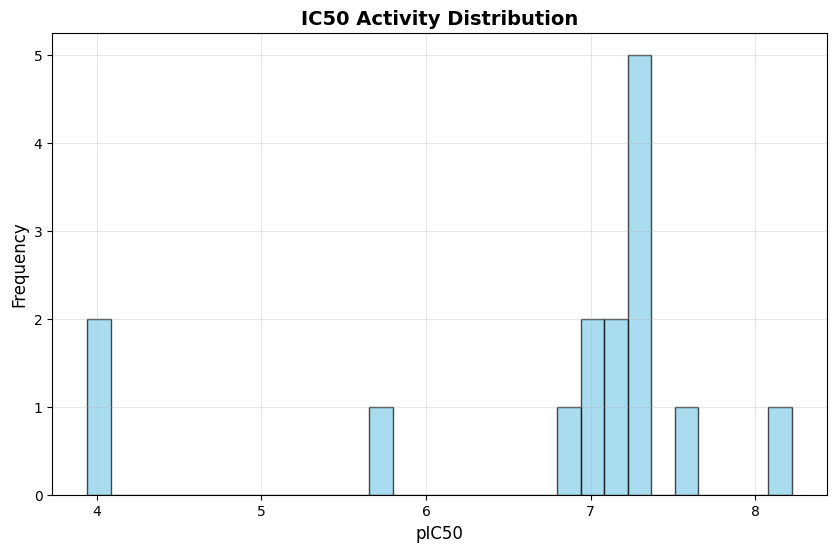

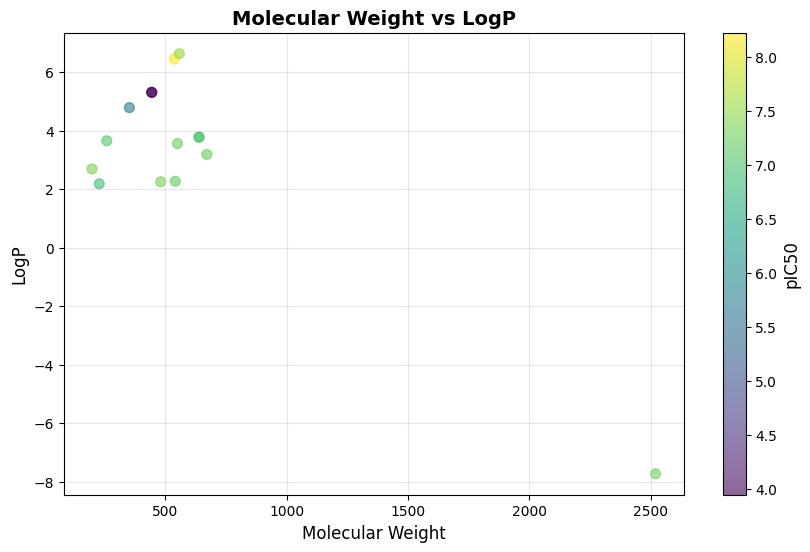

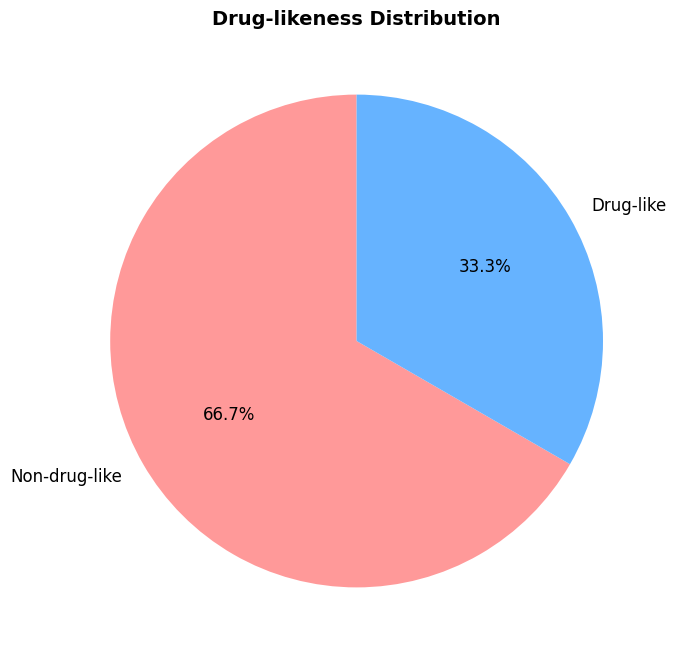

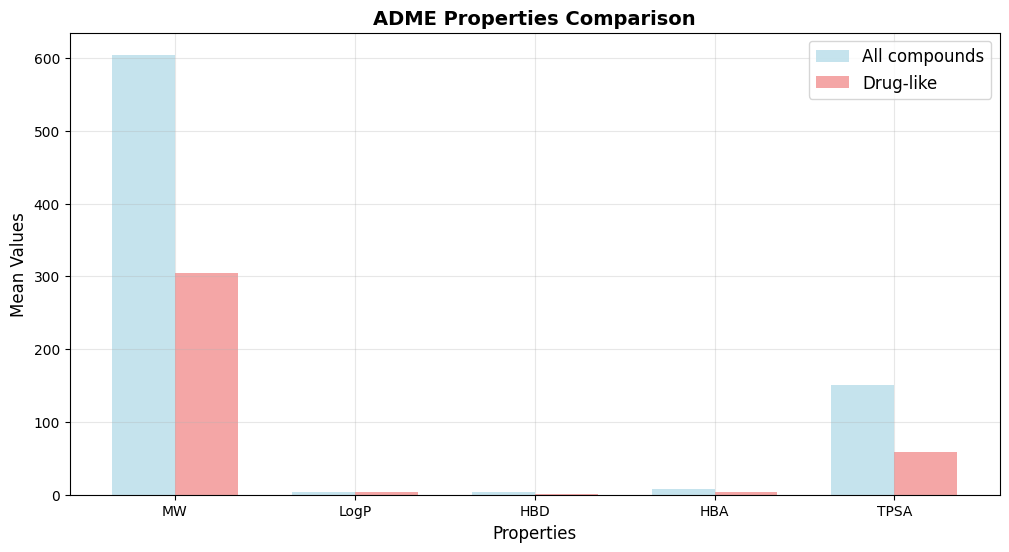

💾 Results saved as: chembl_results_Q04844_IC50_classified.csv
✅ Analysis completed successfully!
📊 Data available in: final_df, drug_like_df, lead_like_df


In [ ]:
# Execute the analysis - MODIFY THESE PARAMETERS
results = run_chembl_analysis(
    uniprot_id="Q04844",
    activity_type="IC50",            # Options: IC50, Ki, Kd, etc.
    activity_threshold=1000          # Threshold in nM to classify as "active"
)

# Unpack results for further analysis
if results[0] is not None:
    final_df, drug_like_df, lead_like_df = results
    print("✅ Analysis completed successfully!")
    print("📊 Data available in: final_df, drug_like_df, lead_like_df")
else:
    print("❌ Analysis failed - check error messages above")

 # COX2 · P35354

🚀 Starting ChEMBL Analysis in Google Colab
Target UniProt ID: P35354
Activity type: IC50
Activity Threshold for 'active': <= 10000 nM
🔍 Searching for target with UniProt ID: P35354
📋 Available targets:


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Cyclooxygenase-2,CHEMBL230,SINGLE PROTEIN
1,Homo sapiens,Cyclooxygenase-2,CHEMBL230,SINGLE PROTEIN
2,Homo sapiens,Cyclooxygenase,CHEMBL2094253,PROTEIN FAMILY
3,Homo sapiens,Prostaglandin E synthase/G/H synthase 2,CHEMBL3885623,PROTEIN FAMILY
4,Homo sapiens,COX-1/COX-2,CHEMBL4523964,SELECTIVITY GROUP


✅ Selected target: Cyclooxygenase-2 (CHEMBL230)
🧪 Querying ALL IC50 bioactivities for target CHEMBL230...
📊 Found 5242 IC50 bioactivities
🧹 Cleaning bioactivity data...
✅ After cleaning: 5242 valid bioactivities
🧬 Retrieving compound structures...
🔍 Fetching data for 4074 unique molecules...
   Processing batch 1/41...
   Processing batch 2/41...
   Processing batch 3/41...
   Processing batch 4/41...
   Processing batch 5/41...
   Processing batch 6/41...
   Processing batch 7/41...
   Processing batch 8/41...
   Processing batch 9/41...
   Processing batch 10/41...
   Processing batch 11/41...
   Processing batch 12/41...
   Processing batch 13/41...
   Processing batch 14/41...
   Processing batch 15/41...
   Processing batch 16/41...
   Processing batch 17/41...
   Processing batch 18/41...
   Processing batch 19/41...
   Processing batch 20/41...
   Processing batch 21/41...
   Processing batch 22/41...
   Processing batch 23/41...
   Processing batch 24/41...
   Processing batch 

,activity_id,assay_description,molecule_chembl_id,standard_units,standard_value,target_chembl_id,units,value,pIC50,smiles,...,HBD,HBA,TPSA,RotBonds,AromaticRings,QED,Lipinski_violations,Lead_like,Drug_like,bioactivity_class
4767,24868264,Inhibition of COX2 (unknown origin),CHEMBL5196097,nM,0.006,CHEMBL230,nM,0.006,11.221849,[11CH3]Oc1ccc(-c2c(-c3ccc(S(N)(=O)=O)cc3)[nH]c...,...,2,3,85.18,4,4,0.559949,0,False,True,Active
2089,2234770,Inhibition of COX2,CHEMBL499068,nM,0.006,CHEMBL230,nM,0.006,11.221849,COc1ccc(-c2c(-c3ccc(S(N)(=O)=O)cc3)[nH]c3ccccc...,...,2,3,85.18,4,4,0.559119,0,False,True,Active
2094,2234775,Inhibition of COX2,CHEMBL525247,nM,0.020,CHEMBL230,nM,0.02,10.698970,Cc1ccc2[nH]c(-c3ccc(S(N)(=O)=O)cc3)c(-c3ccccc3...,...,2,2,75.95,3,4,0.564499,0,False,True,Active
2088,2234769,Inhibition of COX2,CHEMBL499069,nM,0.020,CHEMBL230,nM,0.02,10.698970,COc1ccc(-c2c(-c3ccc(S(C)(=O)=O)cc3)[nH]c3ccccc...,...,1,3,59.16,4,4,0.549414,0,False,True,Active
2092,2234773,Inhibition of COX2,CHEMBL501208,nM,0.020,CHEMBL230,nM,0.02,10.698970,CS(=O)(=O)c1ccc(-c2[nH]c3ccccc3c2-c2ccc(F)cc2)cc1,...,1,2,49.93,3,4,0.552579,1,False,False,Active


📈 Creating visualizations...


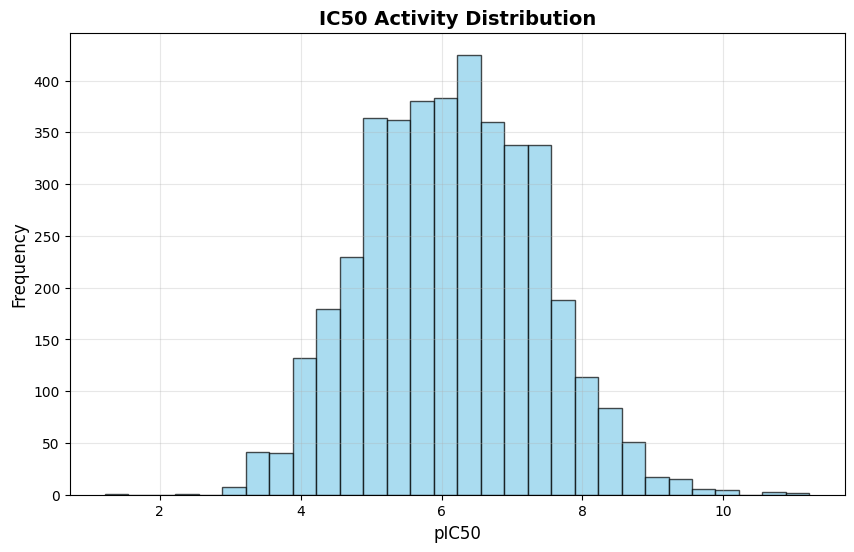

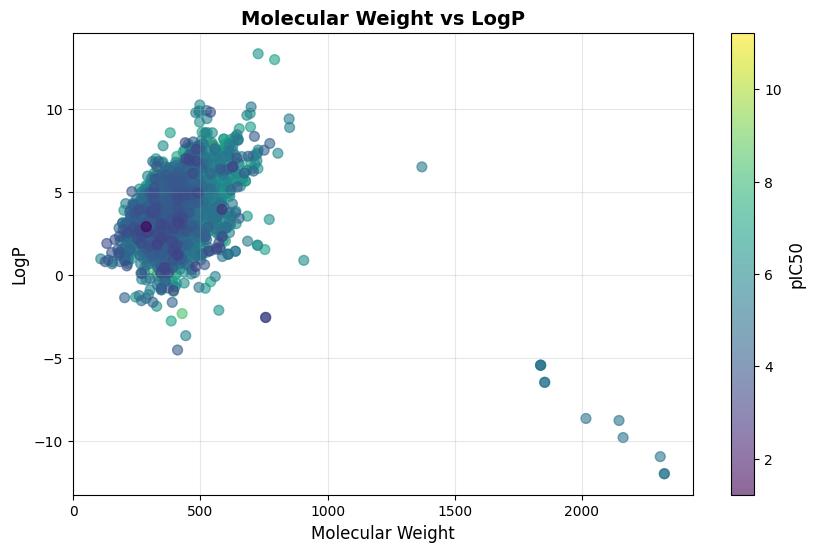

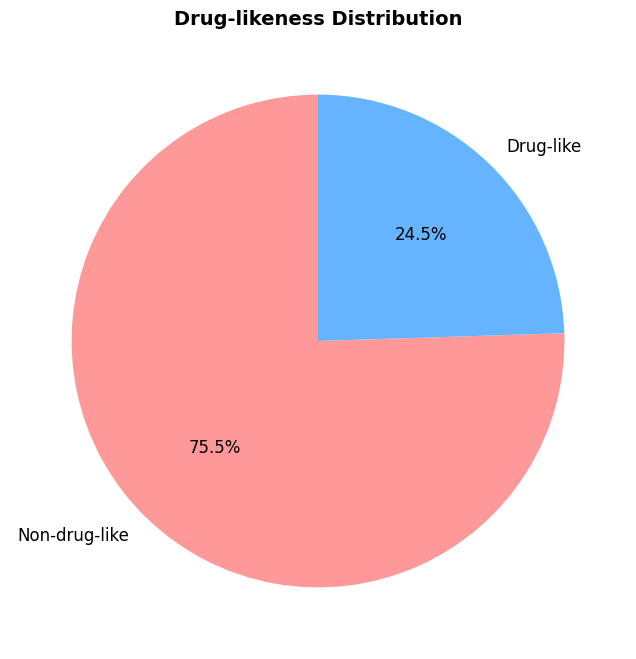

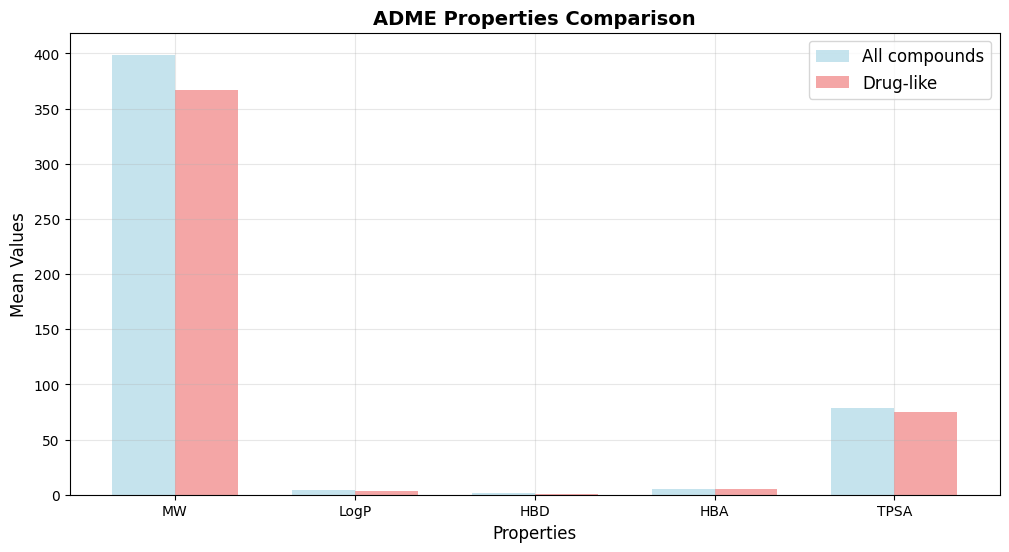

💾 Results saved as: chembl_results_P35354_IC50_classified.csv
✅ Analysis completed successfully!
📊 Data available in: final_df, drug_like_df, lead_like_df


In [ ]:
# Execute the analysis - MODIFY THESE PARAMETERS
results = run_chembl_analysis(
    uniprot_id="P35354",
    activity_type="IC50",            # Options: IC50, Ki, Kd, etc.
    activity_threshold=10000          # Threshold in nM to classify as "active"
)

# Unpack results for further analysis
if results[0] is not None:
    final_df, drug_like_df, lead_like_df = results
    print("✅ Analysis completed successfully!")
    print("📊 Data available in: final_df, drug_like_df, lead_like_df")
else:
    print("❌ Analysis failed - check error messages above")

MAO-B · P27338

🚀 Starting ChEMBL Analysis in Google Colab
Target UniProt ID: P27338
Activity type: IC50
Activity Threshold for 'active': <= 10000 nM
🔍 Searching for target with UniProt ID: P27338
📋 Available targets:


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Monoamine oxidase B,CHEMBL2039,SINGLE PROTEIN
1,Homo sapiens,Monoamine oxidase B,CHEMBL2039,SINGLE PROTEIN
2,Homo sapiens,Monoamine oxidase,CHEMBL2095205,PROTEIN FAMILY


✅ Selected target: Monoamine oxidase B (CHEMBL2039)
🧪 Querying ALL IC50 bioactivities for target CHEMBL2039...
📊 Found 4750 IC50 bioactivities
🧹 Cleaning bioactivity data...
✅ After cleaning: 4750 valid bioactivities
🧬 Retrieving compound structures...
🔍 Fetching data for 4056 unique molecules...
   Processing batch 1/41...
   Processing batch 2/41...
   Processing batch 3/41...
   Processing batch 4/41...
   Processing batch 5/41...
   Processing batch 6/41...
   Processing batch 7/41...
   Processing batch 8/41...
   Processing batch 9/41...
   Processing batch 10/41...
   Processing batch 11/41...
   Processing batch 12/41...
   Processing batch 13/41...
   Processing batch 14/41...
   Processing batch 15/41...
   Processing batch 16/41...
   Processing batch 17/41...
   Processing batch 18/41...
   Processing batch 19/41...
   Processing batch 20/41...
   Processing batch 21/41...
   Processing batch 22/41...
   Processing batch 23/41...
   Processing batch 24/41...
   Processing b

,activity_id,assay_description,molecule_chembl_id,standard_units,standard_value,target_chembl_id,units,value,pIC50,smiles,...,HBD,HBA,TPSA,RotBonds,AromaticRings,QED,Lipinski_violations,Lead_like,Drug_like,bioactivity_class
11,204991,Inhibitory concentration against Monoamine oxi...,CHEMBL348961,nM,0.014,CHEMBL2039,nM,0.014,10.853872,Cc1cc2c(nn1)-c1cc(OCCCC(F)(F)F)ccc1C2=O,...,0,4,52.08,4,2,0.687077,0,False,True,Active
539,5165981,Inhibition of human monoamine oxidase B,CHEMBL972,nM,0.017,CHEMBL2039,nM,0.017,10.769551,C#CCN(C)[C@H](C)Cc1ccccc1,...,0,1,3.24,4,1,0.653025,0,False,True,Active
4673,25576087,Inhibition of human MAO-B using p-tyramine as ...,CHEMBL396778,nM,0.023,CHEMBL2039,nM,0.023,10.638272,C[C@H](NCc1ccc(OCc2cccc(F)c2)cc1)C(N)=O,...,2,3,64.35,7,2,0.825046,0,True,True,Active
515,5128648,Inhibition of human recombinant MAOB expressed...,CHEMBL315361,nM,0.048,CHEMBL2039,nM,0.048,10.318759,O=C(O)c1coc2ccccc2c1=O,...,1,3,67.51,1,2,0.739203,0,False,True,Active
4672,25576086,Inhibition of human MAO-B using p-tyramine as ...,CHEMBL887,nM,0.050,CHEMBL2039,nM,0.05,10.301030,C#CCN[C@@H]1CCc2ccccc21,...,1,1,12.03,2,1,0.670026,0,False,True,Active


📈 Creating visualizations...


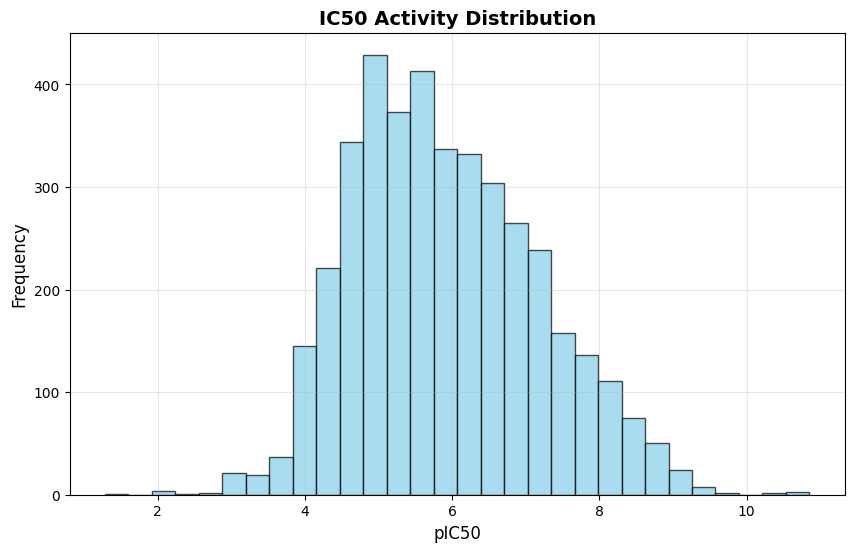

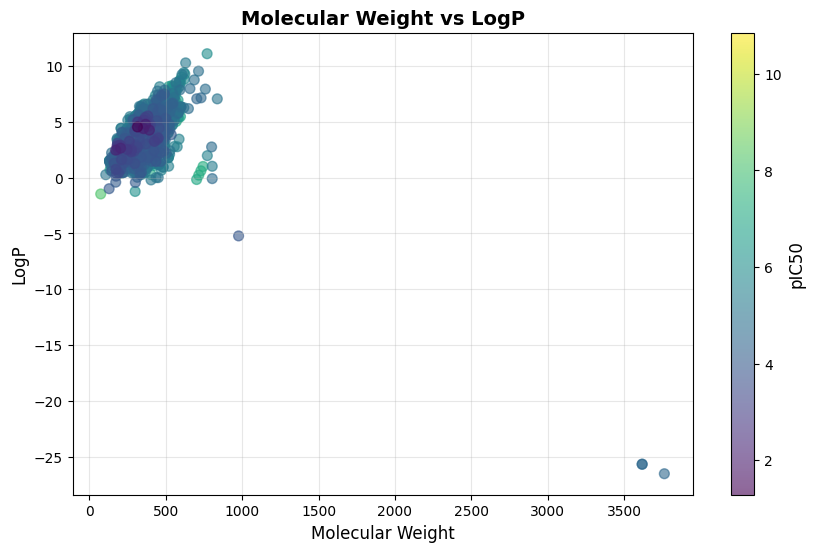

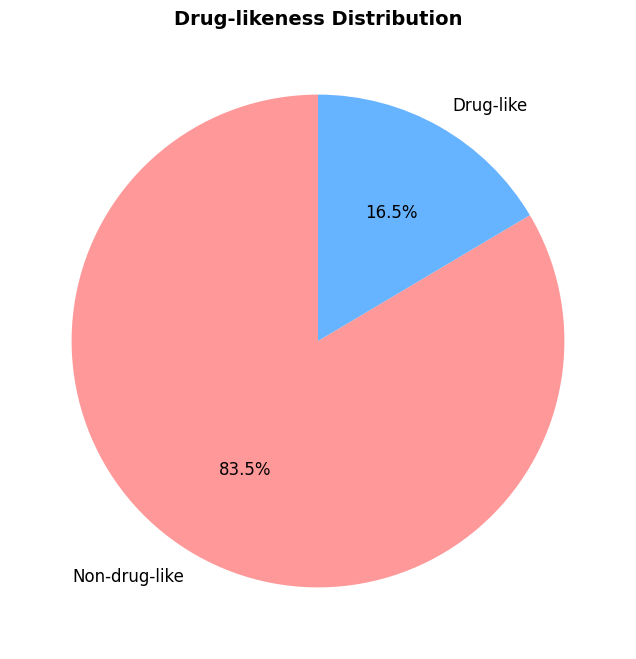

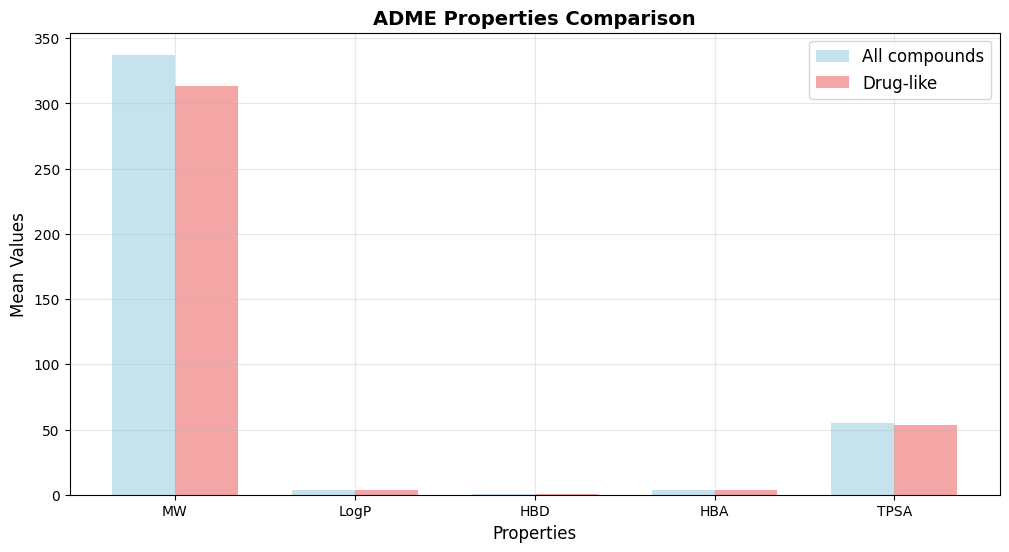

💾 Results saved as: chembl_results_P27338_IC50_classified.csv
✅ Analysis completed successfully!


In [ ]:
# Execute the analysis for MAO-B (UniProt ID: P27338)
results = run_chembl_analysis(
    uniprot_id="P27338",
    activity_type="IC50",
    activity_threshold=10000   # Standard cutoff for initial broad screening (10 µM)
)

# Unpack results for further analysis
if results[0] is not None:
    final_df, drug_like_df, lead_like_df = results
    print("✅ Analysis completed successfully!")
else:
    print("❌ Analysis failed - check error messages above")

# DONE
